$
\def\D{\mathcal{D}}
\def\ipar{m}
\def\R{\mathbb{R}}
\def\del{\partial}
\def\vec{\bf}
\def\priorm{\mu_0}
\def\C{\mathcal{C}}
\def\Acal{\mathcal{A}}
\def\postm{\mu_{\rm{post}}}
\def\iparpost{\ipar_\text{post}}
\def\obs{\vec{d}} 
\def\yobs{\obs^{\text{obs}}}
\def\obsop{\mathcal{B}}
\def\dd{\vec{\bar{d}}}
\def\iFF{\mathcal{F}}
\def\iFFadj{\mathcal{F}^*}
\def\ncov{\Gamma_{\mathrm{noise}}}
$
# Example: Bayesian initial condition inversion in an advection-diffusion problem 

In this example we tackle the problem of quantifying the uncertainty in the solution of an inverse problem governed by a parabolic PDE via the Bayesian inference framework. The underlying PDE is a time-dependent advection-diffusion equation in which we seek to infer an unknown initial condition from spatio-temporal point measurements.

### The Bayesian inverse problem:

Following the Bayesian framework, we utilize 
a Gaussian prior measure $\priorm = \mathcal{N}(\ipar_0,\C_0)$,
with $\C_0=\Acal^{-2}$ where $\Acal$ is an elliptic differential operator as 
described in the PoissonBayesian example, and use an additive
Gaussian noise model. Therefore, the solution of the Bayesian inverse
problem is the posterior measure, $\postm = \mathcal{N}(\iparpost,\C_\text{post})$ with
$\iparpost$ and $\C_\text{post}$.

- The posterior mean $\iparpost$ is characterized as the minimizer of

$$
\begin{aligned}
& \mathcal{J}(\ipar) :=
  \frac{1}{2} \left\| \mathcal{B}u(\ipar) -\obs  \right\|^2_{\ncov^{-1}}
  + \frac 12 \left\| \Acal(\ipar - \ipar_0 \right)\|^2_{L^2(\D)},
\end{aligned}
$$

which can also be interpreted as the regularized functional to be
minimized in deterministic inversion. The observation operator $\mathcal{B}$ extracts the values of the forward solution $u$ on a set of
locations $\{\vec{x}_1, \ldots, \vec{x}_n\} \subset \D$ at
times $\{t_1, \ldots, t_N\} \subset [0, T]$.

- The posterior covariance $\C_{\text{post}}$ is the inverse of the Hessian of $\mathcal{J}(\ipar)$, i.e.,

$$
\C_{\text{post}} = (\iFFadj \ncov^{-1} \iFF + \C_0^{-1})^{-1}.
$$


### The forward problem:

The PDE in the parameter-to-observable map $\iFF$ models diffusive transport
in a domain $\D \subset \R^d$ ($d \in \{2, 3\}$):

$$
\begin{split}
u_t - \kappa\Delta u + \bf{v} \cdot \nabla u &= 0     & \quad \text{in } \D\times(0,T),\\
                                 u(\cdot, 0) &= \ipar & \quad \text{in } \D,\\
                \kappa \nabla u\cdot \vec{n} &= 0     & \quad \text{on } \partial\D \times (0,T).
\end{split}
$$

Here, $\kappa > 0$ is the diffusion coefficient and $T > 0$ is the final
time. The velocity field
$\vec{v}$ is computed by solving the following steady-state
Navier-Stokes equation with the side walls driving the flow:

$$
\begin{aligned}
- \frac{1}{\operatorname{Re}} \Delta \bf{v} + \nabla q + \bf{v} \cdot \nabla \bf{v} &= 0 &\quad&\text{ in }\D,\\
\nabla \cdot \bf{v} &= 0 &&\text{ in }\D,\\
\bf{v} &= \bf{g} &&\text{ on } \partial\D.
\end{aligned}
$$

Here, $q$ is pressure, $\text{Re}$ is the Reynolds number. The Dirichlet boundary data
$\vec{g} \in \R^d$ is given by 
$\vec{g} = \vec{e}_2$ on the left wall of the domain, 
$\vec{g}=-\vec{e}_2$ on the right wall,  and $\vec{g} = \vec{0}$ everywhere else.

### The adjoint problem:

$$
\begin{aligned}
-p_t - \nabla \cdot (p \vec{v}) - \kappa \Delta p  &= -\obsop^* (\obsop u - \obs) & \quad &\text{ in } \D\times (0,T),\\
                                      p(\cdot, T) &= 0             &       &\text{ in } \D,\\ 
(\vec{v}p+\kappa\nabla p)\cdot \vec{n}            &= 0             &       &\text{ on } \partial\D\times (0,T).
\end{aligned}
$$

## 1. Load modules

In [1]:
from __future__ import absolute_import, division, print_function
import copy
import dolfin as dl
import math
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
import sys
sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "../") )
sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "..") + "/applications/ad_diff/" )


sys.path.append( "../" )
from hippylib import *

sys.path.append( "../applications/ad_diff/" )
from model_ad_diff import TimeDependentAD

import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

np.random.seed(1)
# Treat m as x_0
# Remove G_k at first

## 2. Construct the velocity field

In [2]:
def v_boundary(x,on_boundary):
    return on_boundary

def q_boundary(x,on_boundary):
    return x[0] < dl.DOLFIN_EPS and x[1] < dl.DOLFIN_EPS
        
def computeVelocityField(mesh):
    Xh = dl.VectorFunctionSpace(mesh,'Lagrange', 2)
    print(Xh)
    print(type(Xh))
    Wh = dl.FunctionSpace(mesh, 'Lagrange', 1)
    if dlversion() <= (1,6,0):
        XW = dl.MixedFunctionSpace([Xh, Wh])
    else:
        mixed_element = dl.MixedElement([Xh.ufl_element(), Wh.ufl_element()])
        XW = dl.FunctionSpace(mesh, mixed_element)

    Re = 1e2
    # set boundary conditions
    g = dl.Expression(('0.0','(x[0] < 1e-14) - (x[0] > 1 - 1e-14)'), degree=1)
    bc1 = dl.DirichletBC(XW.sub(0), g, v_boundary)
    
    bc2 = dl.DirichletBC(XW.sub(1), dl.Constant(0), q_boundary, 'pointwise')
    
    bcs = [bc1, bc2]
    
    vq = dl.Function(XW)
    (v,q) = dl.split(vq)
    (v_test, q_test) = dl.TestFunctions (XW)
    
    def strain(v):
        return dl.sym(dl.nabla_grad(v))
    
    F = ( (2./Re)*dl.inner(strain(v),strain(v_test))+ dl.inner (dl.nabla_grad(v)*v, v_test)
           - (q * dl.div(v_test)) + ( dl.div(v) * q_test) ) * dl.dx
           
    dl.solve(F == 0, vq, bcs, solver_parameters={"newton_solver":
                                         {"relative_tolerance":1e-4, "maximum_iterations":100}})
    
    plt.figure(figsize=(15,5))
    vh = dl.project(v,Xh)
    qh = dl.project(q,Wh)
    nb.plot(nb.coarsen_v(vh), subplot_loc=121,mytitle="Velocity")
    nb.plot(qh, subplot_loc=122,mytitle="Pressure")
    plt.show()
        
    return v

## 3. Set up the mesh and finite element spaces

<Function space of dimension 4046 (<vector element with 2 components of <CG2 on a triangle>>)>
<class 'dolfin.functions.functionspace.FunctionSpace'>


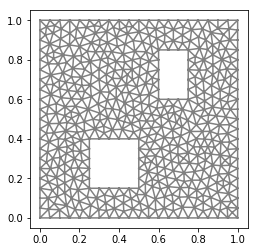

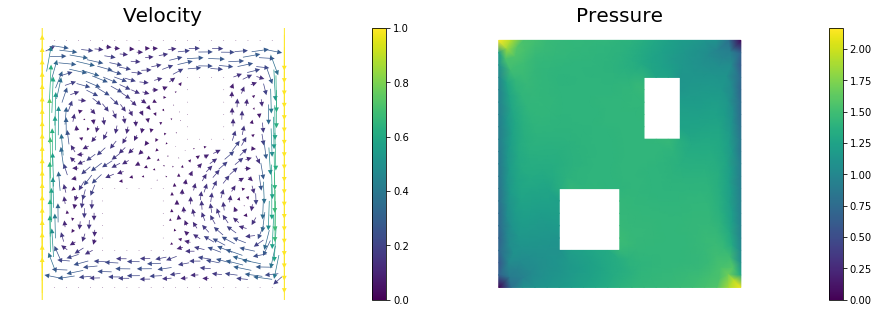

Number of dofs: 2023
(2023, 2023)
<class 'list'>
done with initialization on identity vectors


In [3]:
mesh = dl.Mesh("ad_20.xml") # dl.refine( )
dl.plot(mesh)
wind_velocity = computeVelocityField(mesh)
Vh = dl.FunctionSpace(mesh, "Lagrange", 2)
print("Number of dofs: {0}".format( Vh.dim() ) )
#ndim = 2

u = dl.TrialFunction(Vh)
v = dl.TestFunction(Vh)

a = dl.inner(u,v)*dl.dx
Identity = dl.assemble(a)
Identity2 = dl.assemble(a)
print(Identity.array().shape)
identity_vectors = [dl.Function(Vh) for i in range(Identity.array().shape[0])]
identity2_vectors = [dl.Function(Vh) for i in range(Identity.array().shape[0])]
Kalman_gain_vectors = [dl.Function(Vh) for i in range(Identity.array().shape[0])]
Hinvlr_vectors = [dl.Function(Vh) for i in range(Identity.array().shape[0])]
priorR_vectors = [dl.Function(Vh) for i in range(Identity.array().shape[0])]


[ identity_vectors[i].vector().set_local(Identity.array()[i]) for i in range(Identity.array().shape[0])]
[identity2_vectors[i].vector().set_local(Identity.array()[i]) for i in range(Identity.array().shape[0])]
[   Hinvlr_vectors[i].vector().set_local(Identity.array()[i]) for i in range(Identity.array().shape[0])]
[   priorR_vectors[i].vector().set_local(Identity.array()[i]) for i in range(Identity.array().shape[0])]

print(type(identity_vectors))
print('done with initialization on identity vectors')

## 4. Set up model (prior, true/proposed initial condition)

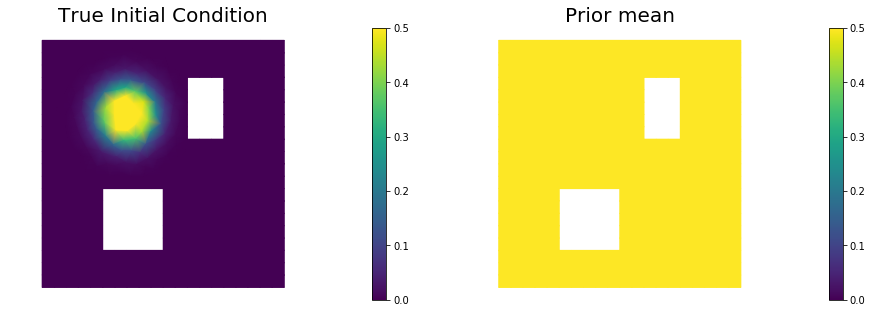

In [4]:
gamma = 1
delta = 8
prior = BiLaplacianPrior(Vh, gamma, delta)

prior.mean = dl.interpolate(dl.Constant(0.5), Vh).vector()
true_initial_condition = dl.interpolate(dl.Expression('min(0.5,exp(-100*(pow(x[0]-0.35,2) +  pow(x[1]-0.7,2))))', degree=5), Vh).vector()
problem = TimeDependentAD(mesh, [Vh,Vh,Vh], 0., 4., 1., .2, wind_velocity, True, prior)

objs = [dl.Function(Vh,true_initial_condition),
        dl.Function(Vh,prior.mean)]

mytitles = ["True Initial Condition", "Prior mean"]
nb.multi1_plot(objs, mytitles)
plt.show()

# nb.plot_pts(targets, misfit.d, mytitle="Observation", subplot_loc=122)


## 5. Generate the synthetic observations

In [5]:
# x_k = F_k x_(k-1) + \xi_k, where xi_k iid gaussian
#ntargets = 250
#targets = np.random.uniform(0.1,0.9, [ntargets, ndim] )
#misfit = PointwiseStateObservation(Vh, targets)
rel_noise = 0.1
utrue = problem.generate_vector(STATE)
x = [utrue, true_initial_condition, None]
print(utrue.times)


ntargets = 80
ndim = 2
rel_noise = 0.1
n_targets_created=0
targets = []
while n_targets_created < ntargets:
    target = np.random.uniform(0.05,0.95, ndim )
    
    box1 = 0.2 < target[0] < 0.6 and 0.15 < target[1] < 0.5
    #box2 = target[0] >= 0.55 and target[1] >= 0.55 and target[0] <=0.9 and target[1] <=0.9 
    box2 = 0.55 < target[0] < 0.85 and 0.55 < target[1] < 0.9
    #     if not box1 and not box2:
    if not box1 and not box2:
        n_targets_created += 1
        targets.append(target)
targets = np.array(targets)

print("Outside of for loop, target shape: " + str(targets.shape))
print("Vh dimension is : " + str( Vh.dim()))
misfit = PointwiseStateObservation(Vh, targets)
print("Vh type is: " + str(type(Vh)))
print("Targets type is: " + str(type(targets)))
print(targets.shape)
print("Outside for loop, misfitD shape: " + str(len(misfit.d)))
print(type(misfit))
MAX = misfit.d.norm("linf")
noise_std_dev = rel_noise * MAX
misfit.noise_variance = noise_std_dev*noise_std_dev 
misfitds = []

[ 0.   0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6  1.8  2.   2.2  2.4  2.6  2.8
  3.   3.2  3.4  3.6  3.8  4. ]
Outside of for loop, target shape: (80, 2)
Vh dimension is : 2023
Vh type is: <class 'dolfin.functions.functionspace.FunctionSpace'>
Targets type is: <class 'numpy.ndarray'>
(80, 2)
Outside for loop, misfitD shape: 80
<class 'hippylib.modeling.misfit.PointwiseStateObservation'>


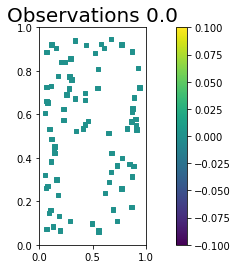

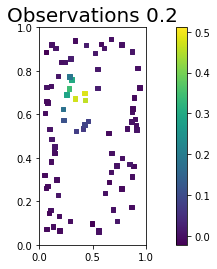

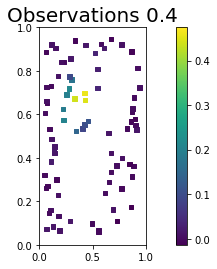

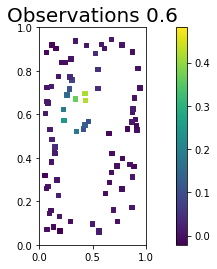

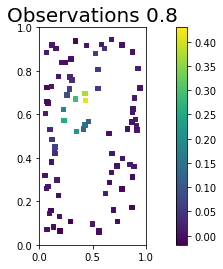

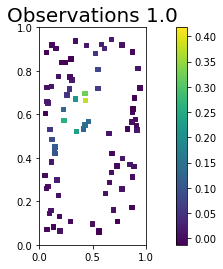

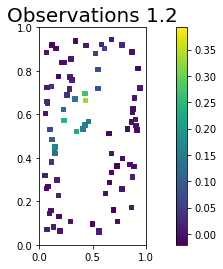

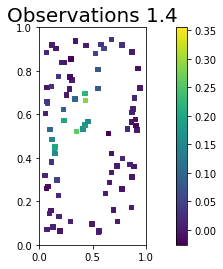

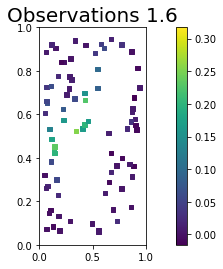

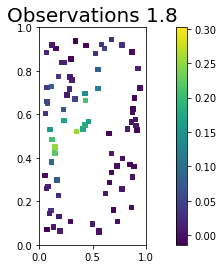

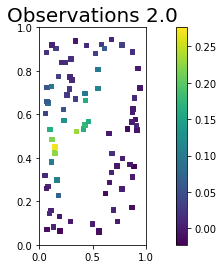

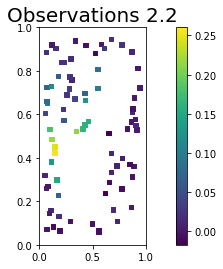

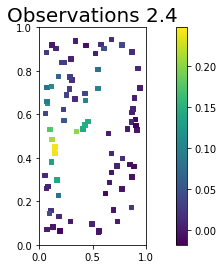

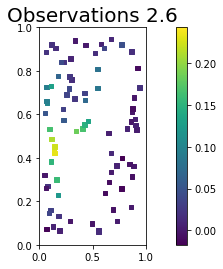

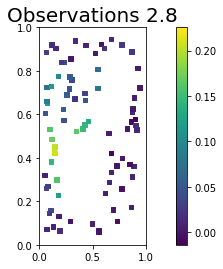

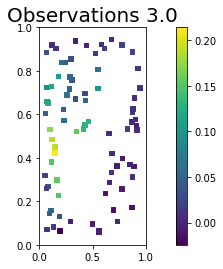

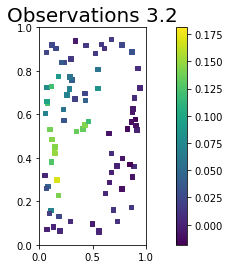

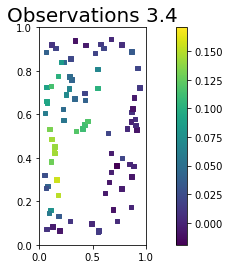

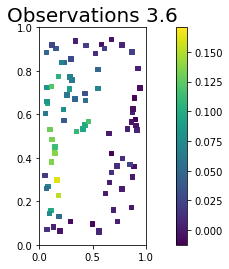

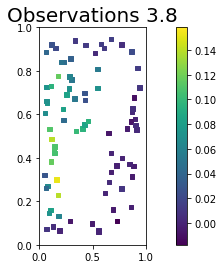

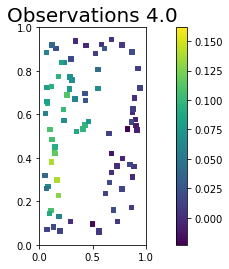

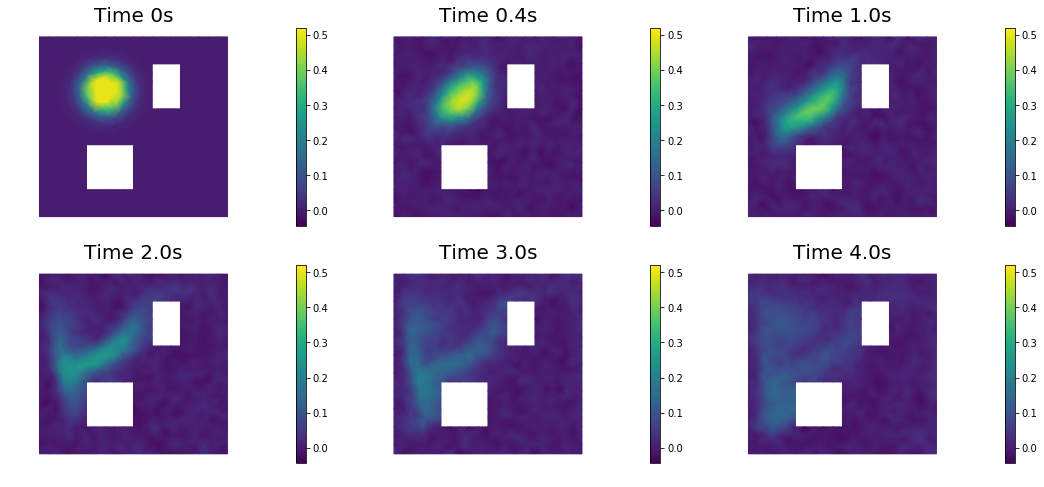

In [6]:
for i in range(len(utrue.times)):
    
    problem.solveFwd(x[STATE], x, 1e-9, process_noise_std_dev=0.01)
    MAX = utrue.norm("linf","linf")
    misfit.B.mult(x[STATE].data[i], misfit.d)
    vmax = max(max(utrue.data[i]), misfit.d.max())
    vmin = max(min(utrue.data[i]), misfit.d.min())
    nb.plot_pts(targets, misfit.d, mytitle="Observations " + str(utrue.times[i]), subplot_loc=122, vmin=vmin, vmax=vmax)
    
    plt.show()
nb.show_solution(Vh, true_initial_condition, utrue, "Solution without noise")

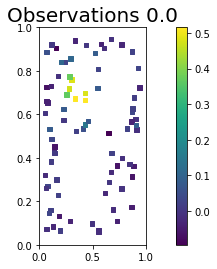

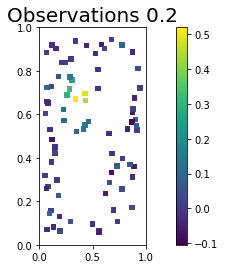

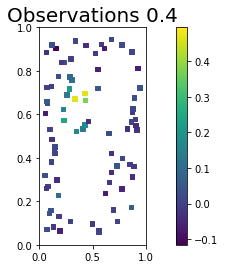

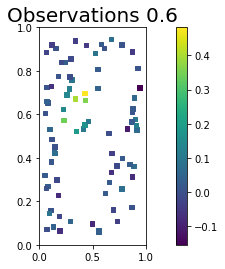

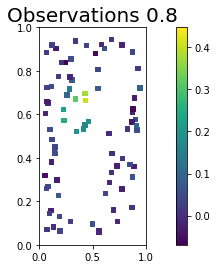

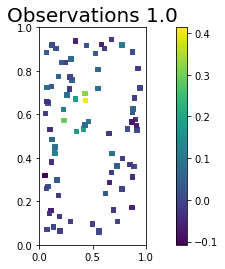

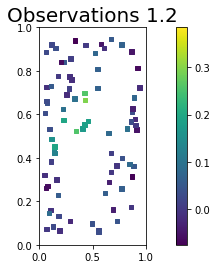

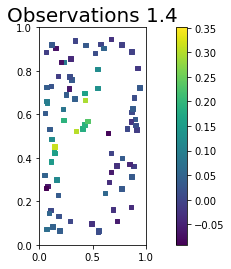

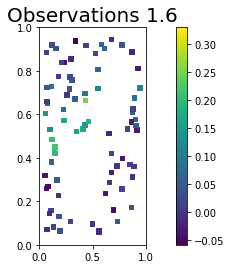

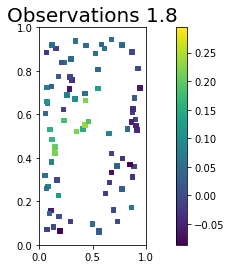

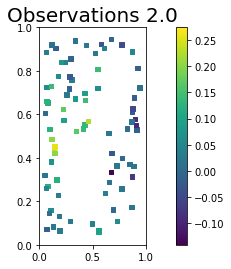

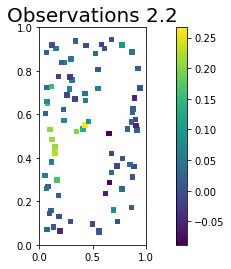

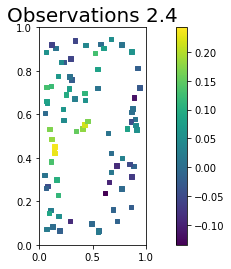

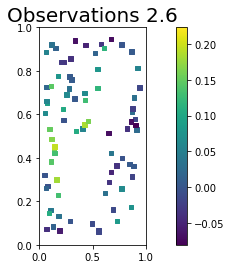

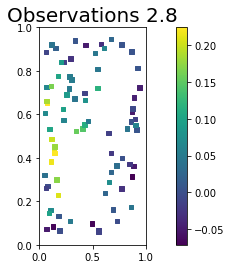

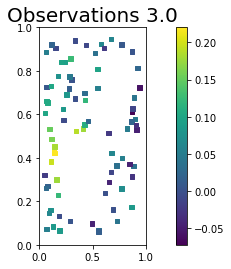

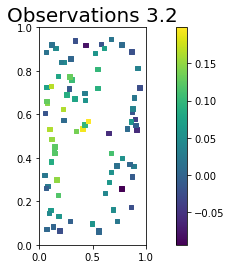

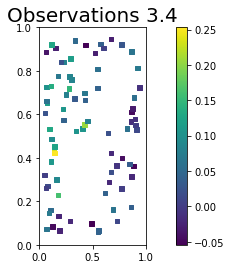

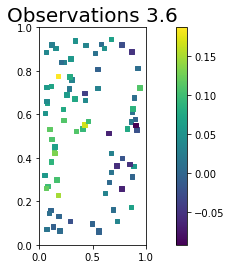

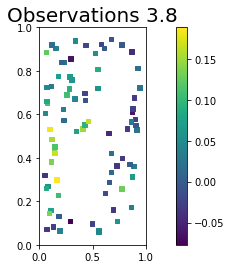

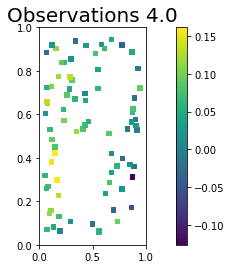

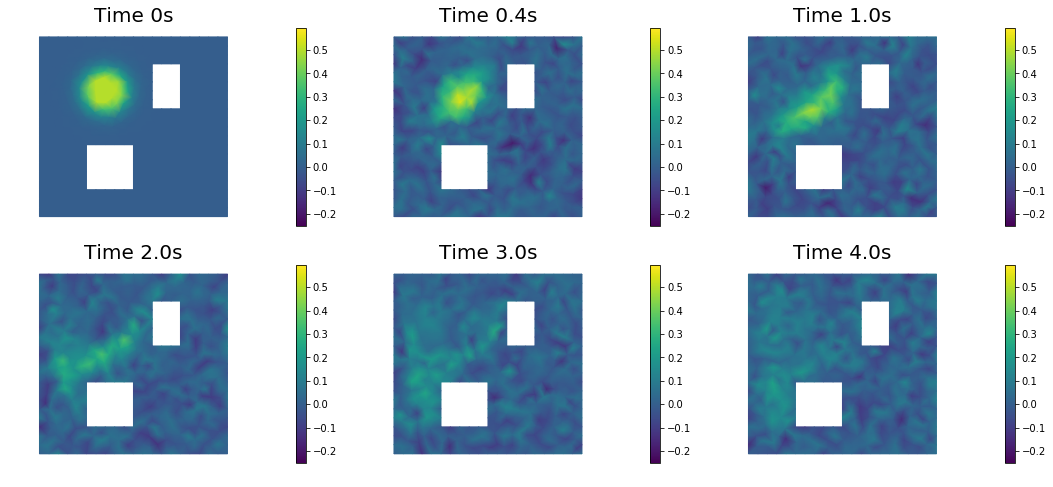

In [13]:
# Only care about this case of utrue:
for i in range(len(utrue.times)):
    noise_std_dev = rel_noise * MAX
    problem.ud.copy(utrue)
    parRandom.normal_perturb(noise_std_dev, problem.ud)
    problem.noise_variance = noise_std_dev*noise_std_dev
    
    plt.show()
    misfit.B.mult(problem.ud.data[i], misfit.d)
    misfitds.append(misfit.d)
    vmax = max( max(utrue.data[i]), misfit.d.max() )
    vmin = min( min(utrue.data[i]), misfit.d.min() )
    
    nb.plot_pts(targets, misfit.d, mytitle="Observations " + str(utrue.times[i]), subplot_loc=122, vmin=vmin, vmax=vmax)
    
    plt.show()
nb.show_solution(Vh, true_initial_condition, problem.ud, "Solution")

In [12]:
print(type(misfit.d))

<class 'dolfin.cpp.la.Vector'>




## 6. Test the gradient and the Hessian of the cost (negative log posterior)

(yy, H xx) - (xx, H yy) =  -1.226597655295368e-13


(array([  4.65661287e-10,   9.31322575e-10,   1.86264515e-09,
          3.72529030e-09,   7.45058060e-09,   1.49011612e-08,
          2.98023224e-08,   5.96046448e-08,   1.19209290e-07,
          2.38418579e-07,   4.76837158e-07,   9.53674316e-07,
          1.90734863e-06,   3.81469727e-06,   7.62939453e-06,
          1.52587891e-05,   3.05175781e-05,   6.10351562e-05,
          1.22070312e-04,   2.44140625e-04,   4.88281250e-04,
          9.76562500e-04,   1.95312500e-03,   3.90625000e-03,
          7.81250000e-03,   1.56250000e-02,   3.12500000e-02,
          6.25000000e-02,   1.25000000e-01,   2.50000000e-01,
          5.00000000e-01,   1.00000000e+00]),
 array([  6.08766617e-02,   1.26062209e-01,   2.51672560e-01,
          5.03991896e-01,   1.00777608e+00,   2.01577168e+00,
          4.03154164e+00,   8.06310826e+00,   1.61262358e+01,
          3.22524746e+01,   6.45049594e+01,   1.29009918e+02,
          2.58019837e+02,   5.16039675e+02,   1.03207935e+03,
          2.06415870e+03

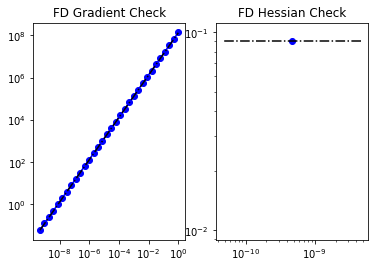

In [11]:
a0 = true_initial_condition.copy()
modelVerify(problem, a0, 1e-12, is_quadratic=True)

## 7. Evaluate the gradient

In [12]:
[u,a,p] = problem.generate_vector()
problem.solveFwd(u, [u,a,p], 1e-12)
problem.solveAdj(p, [u,a,p], 1e-12)
mg = problem.generate_vector(PARAMETER)
grad_norm = problem.evalGradientParameter([u,a,p], mg)
        
print("(g,g) = ", grad_norm)

(g,g) =  23018.776577380715


## 8. The Gaussian approximation of the posterior

Single Pass Algorithm. Requested eigenvectors: 80; Oversampling 20.


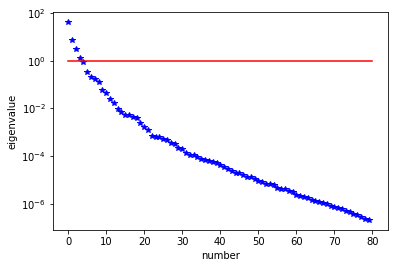

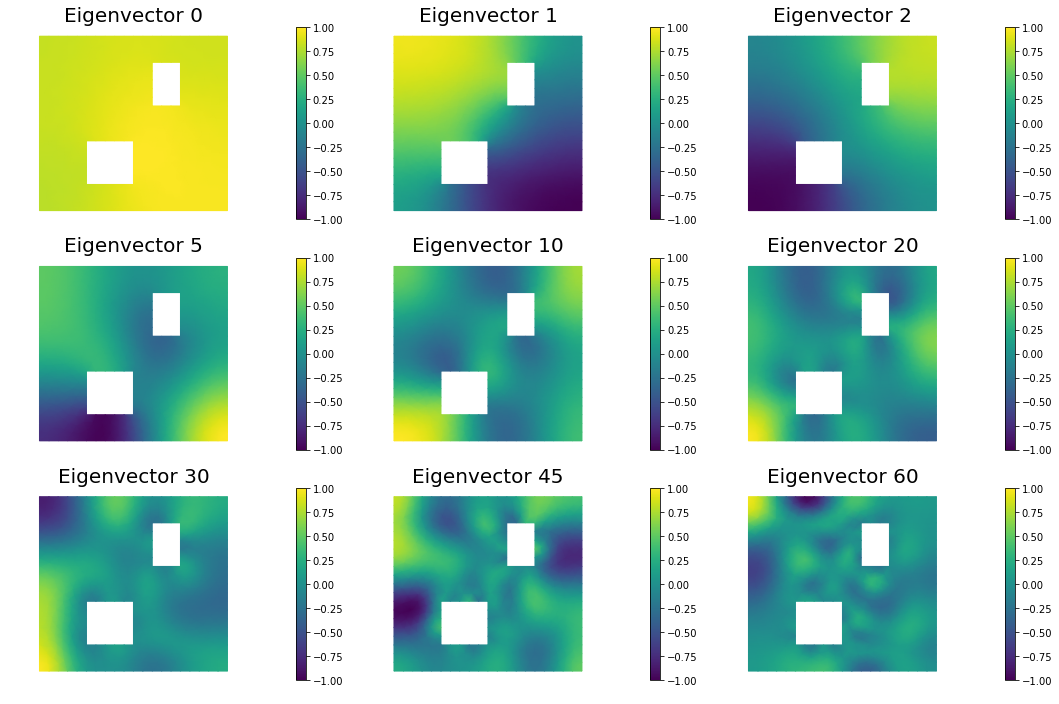

In [13]:
# for i in range(2):
H = ReducedHessian(problem, 1e-12, misfit_only=True) 

k = 80
p = 20
print( "Single Pass Algorithm. Requested eigenvectors: {0}; Oversampling {1}.".format(k,p) )
Omega = MultiVector(x[PARAMETER], k+p)
parRandom.normal(1., Omega)
lmbda, V = singlePassG(H, prior.R, prior.Rsolver, Omega, k)

posterior = GaussianLRPosterior( prior, lmbda, V )
    
# prior = posterior
plt.plot(range(0,k), lmbda, 'b*', range(0,k+1), np.ones(k+1), '-r')
plt.yscale('log')
plt.xlabel('number')
plt.ylabel('eigenvalue')

nb.plot_eigenvectors(Vh, V, mytitle="Eigenvector", which=[0,1,2,5,10,20,30,45,60])


Construct covariance and mean ...hahaha
Form K

In [45]:
vec_size = Vh.dim()

Boperator = misfit.B.array()
print(Boperator.shape)
Hinvlrop = posterior.Hlr.LowRankHinv
np_Hinvlr = np.zeros((vec_size, vec_size))
np_priorR = np.zeros((vec_size, vec_size))
np_identity = np.zeros((vec_size, vec_size))
for i in range(vec_size):
    Hinvlrop.mult(identity_vectors[i].vector(), Hinvlr_vectors[i].vector())
for i in range(vec_size):
    np_Hinvlr[:,i] = Hinvlr_vectors[i].vector()
for i in range(vec_size):
    prior.R.mult(identity_vectors[i].vector(), priorR_vectors[i].vector())
    np_priorR[:,i] = priorR_vectors[i].vector()
K = np.matmul(np.matmul(np_priorR, Boperator.T), np_Hinvlr[:k,:k])
for i in range(vec_size):
    np_identity[:,i] = identity_vectors[i].vector()
cov = np.matmul((np_identity - np.matmul(K, Boperator)), np_priorR)
print(tmp.shape)
newMean = K.dot(misfit.d - misfit.B * prior.mean) + prior.mean

(80, 2023)
(2023, 80)


## 9. Compute the MAP point

In [ ]:
H.misfit_only = False
        
solver = CGSolverSteihaug()
solver.set_operator(H)
solver.set_preconditioner( posterior.Hlr )
solver.parameters["print_level"] = 1
solver.parameters["rel_tolerance"] = 1e-6
solver.solve(a, -mg)
problem.solveFwd(u, [u,a,p], 1e-12)
 
total_cost, reg_cost, misfit_cost = problem.cost([u,a,p])
print("Total cost {0:5g}; Reg Cost {1:5g}; Misfit {2:5g}".format(total_cost, reg_cost, misfit_cost))
    
posterior.mean = a

plt.figure(figsize=(7.5,5))
nb.plot(dl.Function(Vh, a), mytitle="Initial Condition")
plt.show()

nb.show_solution(Vh, a, u, "Solution")

## 10. Prior and posterior pointwise variance fields

In [ ]:
compute_trace = True
if compute_trace:
    post_tr, prior_tr, corr_tr = posterior.trace(method="Estimator", tol=5e-2, min_iter=20, max_iter=2000)
    print("Posterior trace {0:5g}; Prior trace {1:5g}; Correction trace {2:5g}".format(post_tr, prior_tr, corr_tr))
post_pw_variance, pr_pw_variance, corr_pw_variance = posterior.pointwise_variance("Exact")

objs = [dl.Function(Vh, pr_pw_variance),
        dl.Function(Vh, post_pw_variance)]
mytitles = ["Prior Variance", "Posterior Variance"]
nb.multi1_plot(objs, mytitles, logscale=True)
plt.show()

## 11. Draw samples from the prior and posterior distributions

In [ ]:
nsamples = 5
noise = dl.Vector()
posterior.init_vector(noise,"noise")
noise_size = get_local_size(noise)
s_prior = dl.Function(Vh, name="sample_prior")
s_post = dl.Function(Vh, name="sample_post")

pr_max =  2.5*math.sqrt( pr_pw_variance.max() ) + prior.mean.max()
pr_min = -2.5*math.sqrt( pr_pw_variance.min() ) + prior.mean.min()
ps_max =  2.5*math.sqrt( post_pw_variance.max() ) + posterior.mean.max()
ps_min = -2.5*math.sqrt( post_pw_variance.max() ) + posterior.mean.min()

for i in range(nsamples):
    noise.set_local( np.random.randn( noise_size ) )
    posterior.sample(noise, s_prior.vector(), s_post.vector())
    plt.figure(figsize=(15,5))
    nb.plot(s_prior, subplot_loc=121,mytitle="Prior sample", vmin=pr_min, vmax=pr_max)
    nb.plot(s_post, subplot_loc=122,mytitle="Posterior sample", vmin=ps_min, vmax=ps_max)
    plt.show()

Copyright (c) 2016-2018, The University of Texas at Austin & University of California, Merced.
All Rights reserved.
See file COPYRIGHT for details.

This file is part of the hIPPYlib library. For more information and source code
availability see https://hippylib.github.io.

hIPPYlib is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License (as published by the Free Software Foundation) version 2.0 dated June 1991.